# Overview

![alt text](flowchart_final.png "Title")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from gym import spaces
import pickle
pd.options.mode.chained_assignment = None

# Regression models for predicting supply temperature, humidity, and energy use 
Data from Gates-Hillman Building HVAC system

In [2]:
# See Gates_data_processing.ipynb file 
def loadmodel(filename):
    # load the model from disk
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

power_model = loadmodel('Power_prediction.sav')
return_temp_model = loadmodel('CHWRT_prediction.sav')
flow = loadmodel('flow_prediction.sav')

return_temp_scaler = loadmodel('CHWRT_scaler.sav')
power_scaler = loadmodel('Power_scaler.sav')
flow_scaler = loadmodel('CHWF_scaler.sav')

def power_SVM_model(features):
    # features = [action, outdoor conditions, flow rate, supply temperature]
    # num_features = 19
    features = np.array(features).T
    scaled_features = power_scaler.transform(features)
    power = power_model.predict(scaled_features)
    return power 

def return_temp_SVM_model(features):
    # features = [action, outdoor conditions, flow rate(t-1)]
    # num_features = 18
    features = np.array(features).T
    scaled_features = return_temp_scaler.transform(features)
    return_temp = return_temp_model.predict(scaled_features)
    return return_temp

def flow_rate_SVM_model(features):
    # num features = 17
    # features = [action, outdoor conditions, supply_temp(t-1)]
    features = np.array(features).T
    scaled_features = flow_scaler.transform(features)
    flow_rate = flow.predict(scaled_features)
    return flow_rate



/Users/dizadi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVR from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/dizadi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# AI Gym compliant energy and HVAC control model

In [3]:
class EnergyModelEnvironment:

    def __init__(self, df):
        
        self.df = df.copy()
        # data frame with all uncontrollable variables for a given day
        # variables needed for regression models
        # time of day, occupancy, setpoints, entropy, outdoor conditions, etc
        
        self.flow_parameters = ['Time', 'Return Temperature', 'CHWST', 'Action', 'OA Humidity',
       'OA Temperature', '3rd Floor AHU-1|SA Airflow',
       '3rd Floor AHU-2|SA Airflow', '3rd Floor AHU-3|SA Airflow',
       '3rd Floor AHU-7|SA Airflow', '3rd Floor AHU-8|SA Airflow',
       'Level 2 AHU-4|SA Airflow', 'Level 2 AHU-5|SA Airflow',
       'Roof AHU-10|SA Airflow', 'Roof AHU-11|SA Airflow',
       'Roof AHU-12|SA Airflow', 'Roof AHU-9|SA Airflow',
       '3rd Floor AHU-1|RA Humidity', '3rd Floor AHU-2|RA Humidity',
       '3rd Floor AHU-3|RA Humidity', '3rd Floor AHU-7|RA Humidity',
       '3rd Floor AHU-8|RA Humidity', 'Level 2 AHU-4|RA Humidity',
       'Level 2 AHU-5|RA Humidity', 'Roof AHU-10|RA Humidity',
       'Roof AHU-11|RA Humidity', 'Roof AHU-12|RA Humidity',
       'Roof AHU-9|RA Humidity', 'Run Time']
        
        self.return_temp_parameters = ['Time', 'Flow Rate', 'CHWST', 'Action',
       'OA Humidity', 'OA Temperature', '3rd Floor AHU-1|SA Airflow',
       '3rd Floor AHU-2|SA Airflow', '3rd Floor AHU-3|SA Airflow',
       '3rd Floor AHU-7|SA Airflow', '3rd Floor AHU-8|SA Airflow',
       'Level 2 AHU-4|SA Airflow', 'Level 2 AHU-5|SA Airflow',
       'Roof AHU-10|SA Airflow', 'Roof AHU-11|SA Airflow',
       'Roof AHU-12|SA Airflow', 'Roof AHU-9|SA Airflow',
       '3rd Floor AHU-1|RA Humidity', '3rd Floor AHU-2|RA Humidity',
       '3rd Floor AHU-3|RA Humidity', '3rd Floor AHU-7|RA Humidity',
       '3rd Floor AHU-8|RA Humidity', 'Level 2 AHU-4|RA Humidity',
       'Level 2 AHU-5|RA Humidity', 'Roof AHU-10|RA Humidity',
       'Roof AHU-11|RA Humidity', 'Roof AHU-12|RA Humidity',
       'Roof AHU-9|RA Humidity', 'Run Time']
        
        self.power_parameters = ['Time', 'Flow Rate', 'Return Temperature', 'CHWST', 'Action',
       'OA Humidity', 'OA Temperature', '3rd Floor AHU-1|SA Airflow',
       '3rd Floor AHU-2|SA Airflow', '3rd Floor AHU-3|SA Airflow',
       '3rd Floor AHU-7|SA Airflow', '3rd Floor AHU-8|SA Airflow',
       'Level 2 AHU-4|SA Airflow', 'Level 2 AHU-5|SA Airflow',
       'Roof AHU-10|SA Airflow', 'Roof AHU-11|SA Airflow',
       'Roof AHU-12|SA Airflow', 'Roof AHU-9|SA Airflow',
       '3rd Floor AHU-1|RA Humidity', '3rd Floor AHU-2|RA Humidity',
       '3rd Floor AHU-3|RA Humidity', '3rd Floor AHU-7|RA Humidity',
       '3rd Floor AHU-8|RA Humidity', 'Level 2 AHU-4|RA Humidity',
       'Level 2 AHU-5|RA Humidity', 'Roof AHU-10|RA Humidity',
       'Roof AHU-11|RA Humidity', 'Roof AHU-12|RA Humidity',
       'Roof AHU-9|RA Humidity', 'Run Time']
        
        self.state_parameters = self.df.columns[self.df.columns!='Action']
        
        # define the action space
        self.actions = {'ON':1, 'OFF':0}
        self.possible_actions = {0,1}
        self.action_size = 2
        
        #define the state space
        self.N = len(df.index)
        self.state_size = len(df.columns)-1 #state variables = [time, cooling load, outdoor conditions (assumed 2), flow rate, supply temp, energy use]
        
        self.setpoint = 54
        # setpoint for supply temperature
        
        self.coin = 10 
        # reward value (arbitrary)
    
        self.return_temp = self.df['Return Temperature'].iloc[0]
        # initialize the supply temp to the set point
        
        self.flow_rate = self.df['Flow Rate'].iloc[0]
        
        self.power = 0
        # initialize the energy use at the beginning of the day
        
        self.current_step = 1
        # current step = time step = time of day
        
        self.reward = 0
        # initialize the reward function
        
        self.baseline_power = self.df['Power Actual'].iloc[0]
        
        self.done = False        
        
### REGRESSION MODELS ###

    def get_power(self):
        power_features = self.df[self.power_parameters].iloc[self.current_step].values.reshape(-1,1)
        power = power_SVM_model(power_features)
        return power
    
    def get_return_temp(self):
        return_temp_features = self.df[self.return_temp_parameters].iloc[self.current_step].values.reshape(-1,1)
        return_temp = return_temp_SVM_model(return_temp_features)
        return return_temp
    
    def get_flow_rate(self):
        flow_features = self.df[self.flow_parameters].iloc[self.current_step-1].values.reshape(-1,1)
        self.flow_rate = flow_rate_SVM_model(flow_features)
        return self.flow_rate
    
#########################

### REINFORCEMENT LEARNING FUNCTIONS ###

    def get_state(self, state):
        # state is the current environment at that time step
        state = self.df[self.state_parameters].iloc[self.current_step].values.reshape(-1,1)
        return state

    def get_reward(self):
        high = 1
        low = 0.75
        
        # reward for temperature control
        if self.return_temp < self.setpoint-low:
            self.reward-=self.coin
        elif self.return_temp > self.setpoint+high:
            self.reward-=self.coin
        
        # do NOT let the temperature dip below 51 or go above 60
        
        if self.return_temp < self.setpoint-3:
            self.reward-=self.coin*100
        elif self.return_temp > self.setpoint+6:
            self.reward -= self.coin*100
        
        # reward for energy use
        if self.power > self.baseline_power:
            self.reward-=self.coin
        elif self.power < self.baseline_power:
            self.reward+=self.coin
            
        return self.reward
    
    def step(self, action):
        # action is whether or not to send a cooling request
        # binary decision yes = 1 no = 0 
        # get the action from the NN
        
        if self.current_step == self.N:
            self.done = True
        else:
            self.done=False
            
        self.df['Action'].iloc[self.current_step] = action
        
        self.flow_rate = self.get_flow_rate()
        if self.flow_rate<0:
            self.flow_rate = 0
        self.df['Flow Rate'].iloc[self.current_step] = self.flow_rate
        
        self.return_temp = self.get_return_temp()
        self.df['Return Temperature'].iloc[self.current_step] = self.return_temp
        
        self.power = self.get_power()
        self.df['Power'].iloc[self.current_step] = self.power
        
        self.baseline_power = self.df['Power Actual'].iloc[self.current_step]
        
        observations = self.next_observation()
        reward = self.get_reward()
        #self.current_step+=1
        next_state = observations[:self.state_size]
                    
        return next_state,observations, reward, self.done

    def next_observation(self):
        frame = np.array(self.df.iloc[self.current_step,:self.state_size])
        obs = np.append(frame, [[self.return_temp, self.power]]) # all of the monitoring values that assess state
        return obs
    
##########################################

### RENDERING AND PROGRAM FUNCTIONS ###
    def reset(self):
        self.current_step=0;
        self.state = self.get_state(self.current_step)
        self.reward = 0
        return self.state

    def render(self,action):
        print(f"Step: {self.current_step}")
        print(f"Power: {self.power}")
        print(f"Baseline Power: {self.baseline_power}")
        print(f"Supply Temp: {self.return_temp}")
        print(f"Cooling Request: {action}")
        print(f"Reward: {self.reward}\n")

    def close(self):
        pass


# Neural Network framework for controlling the above model

In [4]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam


Using TensorFlow backend.


In [5]:
class DQNAgent:
    def __init__(self,state_size,action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        # modify any of these parameters
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()
        
    def build_model(self):
        model = Sequential()
        
        #### modify number of layers, layers' activation functions and dimensions
        model.add(Dense(64,input_dim=self.state_size, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(self.action_size, activation = 'relu'))
        ####
        
        ### modify loss function, optimizer, learning rate
        model.compile(loss='mse', optimizer = Adam(lr=self.learning_rate))
        
        return model
    
    def remember(self, state, action, reward, next_state,done):
        self.memory.append((state, action,reward,next_state,done))
    
    def act(self,state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward+self.gamma*np.amax(self.model.predict(next_state)[0]))
            
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
        if self.epsilon > self.epsilon_min:
            self.epsilon *=self.epsilon_decay
        
    def load(self,name):
        self.model.load_weights(name)
    
    def save_weights(self, name):
        self.model.save_weights(name)
    
    def summary(self):
        self.model.summary()
        
    def get_weights(self):
        self.model.get_weights()
    

# Implementation of neural network in energy model

In [6]:
def RL_model(episodes, batch_size, df, df_raw, init_weights=None):
   
    
    env = EnergyModelEnvironment(df)
    
    state_size = env.state_size 
    action_size = env.action_size   
    
    max_step = len(df.index)
    
    agent = DQNAgent(state_size,action_size)
    agent.load('model.h5')
    
    done = False
    history = []
    
    
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state,[1,state_size])
        
        for time_step in range(1,max_step):
            env.current_step = time_step
            action = agent.act(state)
            next_state,observations,reward,done = env.step(action)
            reward = env.reward
            next_state = np.reshape(next_state, [1,state_size])
            agent.remember(state,action,reward,next_state,done)
            state = next_state
            
            #if env.current_step % 60* == 0:
                #print("Hour: ", env.current_step/60)
                #env.render(action)
            
        print("EPISODE: {}/{} REWARD: {}".format(e+1,episodes, reward))
        history.append(reward)
        
        if len(agent.memory)>batch_size:
            agent.replay(batch_size)
    
    fig_name = 'RL_model_'+str(episodes)+'episodes'
    make_plots(env.df, df_raw, fig_name)
    plt.figure()
    plt.plot(np.arange(episodes), history)
    #plt.plot(np.arange(e), 0*np.arange(e)-13420, linetype='--')
    plt.title('Reward vs Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.savefig('reward_500ep_model_1.png')
    
    agent.save_weights('model.h5') 
    
    return history, env.df, agent

### Create dataframe to pass to the simulation

In [56]:
import pandas as pd

data = pd.read_csv('model_data.csv')
data_raw = pd.read_csv('Processed_8-28.csv')

def make_plots(df, df_raw, name):
    mpl.style.use('seaborn')
    fig,axs = plt.subplots(2,2, figsize=(10,8))
    min_to_hr = 60
    
    axs[1,0].plot(df['Time'][1:]/min_to_hr, df['Return Temperature'][1:], label = 'Model')
    axs[1,0].plot(df_raw['Entry']/min_to_hr, df_raw['CHWRT'], label='Raw Data')
    axs[1,0].set_title('Return Temperature')
    #axs[0,0].legend()

    axs[0,0].plot(df['Time'][1:]/min_to_hr,df['Action'][1:])
    axs[0,0].plot(df_raw['Entry']/min_to_hr, df_raw['Chilled Water Request'])
    axs[0,0].set_title('HVAC Action')
    #axs[1,0].legend()
    
    axs[0,1].plot(df['Time']/min_to_hr, df['Flow Rate'])
    axs[0,1].plot(df_raw['Entry']/min_to_hr, df_raw['CHW Flowrate'])
    axs[0,1].set_title('Flow Rate')
    #axs[1,1].legend()
    
    axs[1,1].plot(df['Time'][1:]/min_to_hr, df['Power'][1:])
    axs[1,1].plot(df['Time'][1:]/min_to_hr, df['Power Actual'][1:])
    axs[1,1].set_title('Energy Use')
    #axs[0,1].legend()
    
    #handles, labels = axs.get_legend_handles_labels()
    fig.legend(loc='upper center')
    
    plt.savefig(name+'.png')


# Implementation of predictive models, virtual environment and RL agent

EPISODE: 1/500 REWARD: -7800
EPISODE: 2/500 REWARD: -8240
EPISODE: 3/500 REWARD: -8220
EPISODE: 4/500 REWARD: -8170
EPISODE: 5/500 REWARD: -8120
EPISODE: 6/500 REWARD: -8250
EPISODE: 7/500 REWARD: -7920
EPISODE: 8/500 REWARD: -7900
EPISODE: 9/500 REWARD: -8490
EPISODE: 10/500 REWARD: -8170
EPISODE: 11/500 REWARD: -7970
EPISODE: 12/500 REWARD: -7900
EPISODE: 13/500 REWARD: -7820
EPISODE: 14/500 REWARD: -8010
EPISODE: 15/500 REWARD: -7860
EPISODE: 16/500 REWARD: -7790
EPISODE: 17/500 REWARD: -7830
EPISODE: 18/500 REWARD: -7950
EPISODE: 19/500 REWARD: -7530
EPISODE: 20/500 REWARD: -7680
EPISODE: 21/500 REWARD: -7700
EPISODE: 22/500 REWARD: -7710
EPISODE: 23/500 REWARD: -7810
EPISODE: 24/500 REWARD: -8070
EPISODE: 25/500 REWARD: -7880
EPISODE: 26/500 REWARD: -7830
EPISODE: 27/500 REWARD: -7920
EPISODE: 28/500 REWARD: -7610
EPISODE: 29/500 REWARD: -7540
EPISODE: 30/500 REWARD: -7970
EPISODE: 31/500 REWARD: -8190
EPISODE: 32/500 REWARD: -8080
EPISODE: 33/500 REWARD: -7740
EPISODE: 34/500 REW

EPISODE: 269/500 REWARD: -7390
EPISODE: 270/500 REWARD: -7180
EPISODE: 271/500 REWARD: -7250
EPISODE: 272/500 REWARD: -7110
EPISODE: 273/500 REWARD: -7320
EPISODE: 274/500 REWARD: -7290
EPISODE: 275/500 REWARD: -7400
EPISODE: 276/500 REWARD: -7340
EPISODE: 277/500 REWARD: -7550
EPISODE: 278/500 REWARD: -6780
EPISODE: 279/500 REWARD: -7270
EPISODE: 280/500 REWARD: -7170
EPISODE: 281/500 REWARD: -7110
EPISODE: 282/500 REWARD: -7240
EPISODE: 283/500 REWARD: -7110
EPISODE: 284/500 REWARD: -7240
EPISODE: 285/500 REWARD: -7200
EPISODE: 286/500 REWARD: -7290
EPISODE: 287/500 REWARD: -7160
EPISODE: 288/500 REWARD: -7180
EPISODE: 289/500 REWARD: -7000
EPISODE: 290/500 REWARD: -7290
EPISODE: 291/500 REWARD: -7050
EPISODE: 292/500 REWARD: -7100
EPISODE: 293/500 REWARD: -7210
EPISODE: 294/500 REWARD: -7150
EPISODE: 295/500 REWARD: -7410
EPISODE: 296/500 REWARD: -7060
EPISODE: 297/500 REWARD: -7220
EPISODE: 298/500 REWARD: -7170
EPISODE: 299/500 REWARD: -7080
EPISODE: 300/500 REWARD: -7200
EPISODE:

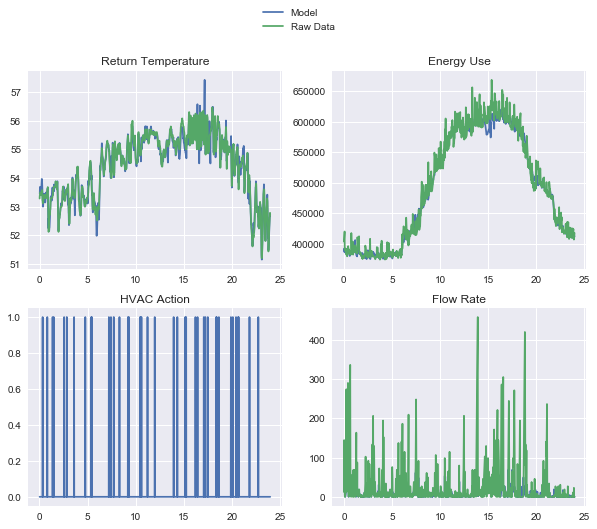

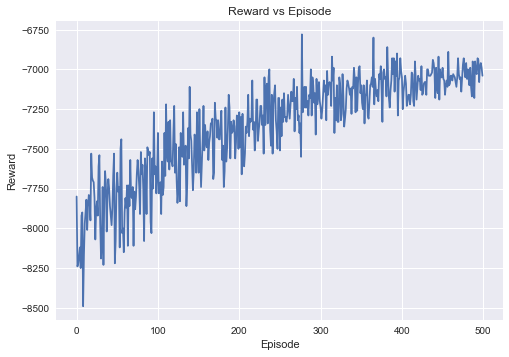

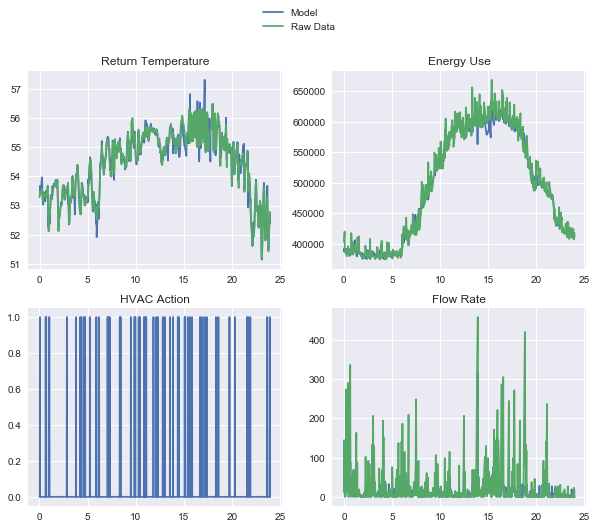

In [22]:
episodes =500
batch_size = 32
history, df, agent = RL_model(episodes, batch_size, data, data_raw)

In [86]:
energy_use = df['Power'].sum()*60*10**-9*.28
print("Daily Energy Use: ", energy_use)
peak_power = df['Power'].max()
raw_peak_power = df['Power Actual'].max()
print("Model Peak Power: ", peak_power)
print("Actual Peak Power: ", raw_peak_power)

Daily Energy Use:  11.888470068303741
Model Peak Power:  621225.1158276502
Actual Peak Power:  668184


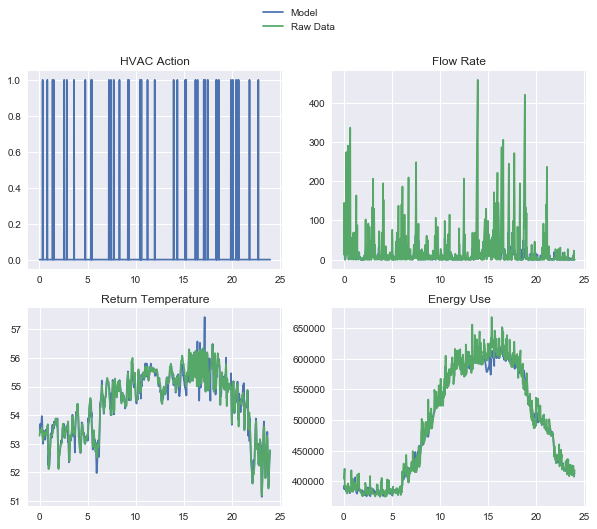

In [38]:
make_plots(df, data_raw, 'RL_500eps')

In [63]:
def cross_validation_test(test_df,test_df_raw, agent):
    # run the agent's strategy through a different day's HVAC data
    
    print("Cross Validation Testing")
    
    test_env = EnergyModelEnvironment(test_df)
    state_size = test_env.state_size 
    action_size = test_env.action_size 
    state = test_env.reset()
    state = np.reshape(state,[1,state_size])  
        
    max_step = len(df.index)
    
    for time_step in range(1,max_step):
        test_env.current_step = time_step
        action = agent.act(state)
        next_state,observations,reward,done = test_env.step(action)
        reward = test_env.reward
        next_state = np.reshape(next_state, [1,state_size])
        agent.remember(state,action,reward,next_state,done)
        state = next_state
        
    print("Test Reward: ", reward)
    make_plots(test_env.df, test_df_raw, "cross_validation_testing")
    
    return test_env.df
    
    

Cross Validation Testing
Test Reward:  -9890
Final Reward:  -11920


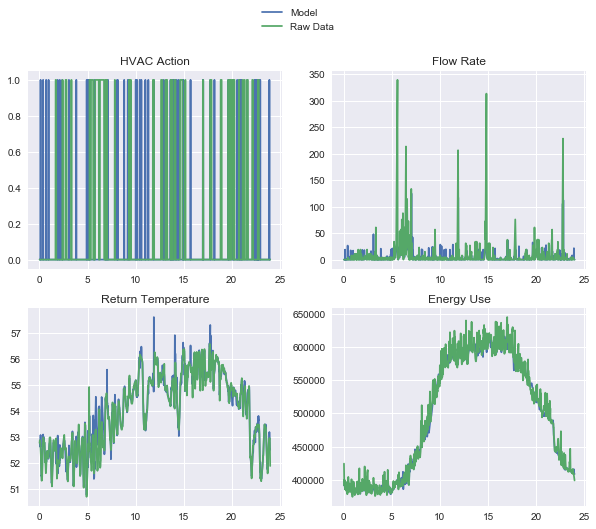

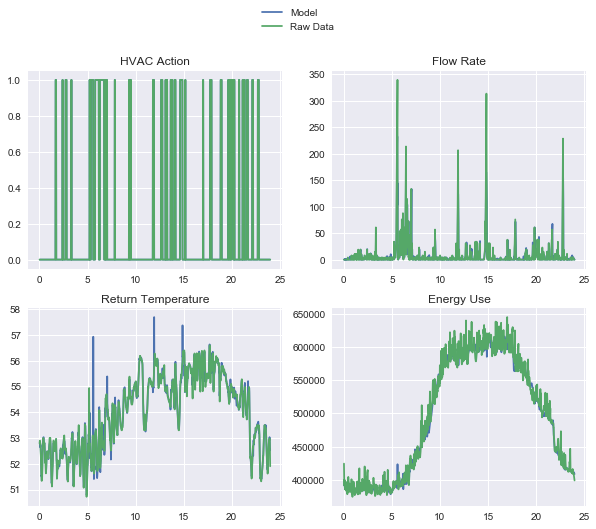

In [72]:
test_data_raw = pd.read_csv("GatesData8-29.csv")
test_data = pd.read_csv('test_model_data.csv')
test_df_sim = cross_validation_test(test_data, test_data_raw, agent)
test_reward, test_df = raw_model(test_data, test_data_raw)

In [83]:
energy_use = test_data['Power Actual'].sum()*60*10**-9*.28
energy_nn = test_df_sim['Power'].sum()*60*10**-9*.28
print("Actual Daily Energy Use: ", energy_use, 'MWh')
print("Neural Agent Energy Use: ", energy_nn, "MWh")

peak_power = test_df_sim['Power'].max()
raw_peak_power = test_data['Power Actual'].max()
print("Actual Peak Power: ", raw_peak_power)
print("Neural Agent Peak Power: ", peak_power)

percent_energy = (1-energy_use/energy_nn)*100
percent_peak_power = (1-raw_peak_power/peak_power)*100
print("Energy reduction: ", np.round(percent_energy,3))
print("Peak Power Reduction: ", np.round(percent_peak_power, 3))

lb_per_MWh = 1559

print("CO2 saved: ", (energy_use-energy_nn)*lb_per_MWh)
print(energy_use-energy_nn)
print(raw_peak_power-peak_power)

Actual Daily Energy Use:  12.019323724800003 MWh
Neural Agent Energy Use:  11.954007126540057 MWh
Actual Peak Power:  645367
Neural Agent Peak Power:  617757.8213181106
Energy reduction:  -0.546
Peak Power Reduction:  -4.469
CO2 saved:  101.8285766872554
0.06531659825994574
27609.178681889432


# Implementation of a simple control strategy 

Sanity check

Final Reward:  -8550


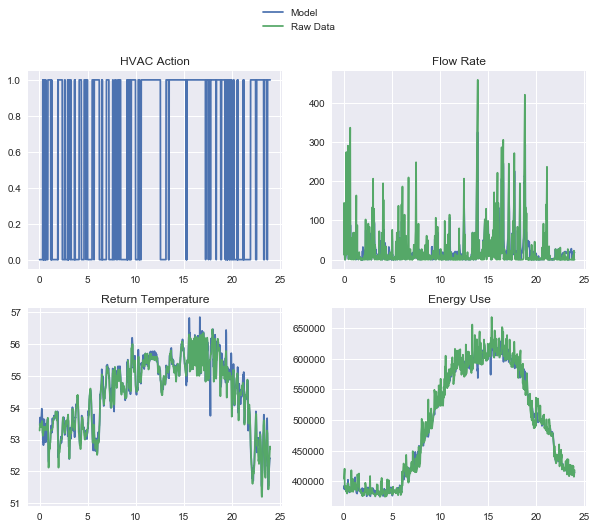

In [39]:
def control_strategy(return_temp):
    setpoint = 54 # setpoint for return temp 
    low = 0.75
    high = 1
    if return_temp > setpoint+high or return_temp < setpoint-low:
        action = 1
    else:
        action = 0
    return action

def control_model(df, df_raw):

    # control the energy model using PID controller
    env = EnergyModelEnvironment(df)
    
    max_step = len(df.index)
    state_size = len(df.columns)-1
    done = False
    
    for time_step in range(1,max_step):
        env.current_step = time_step
        action = control_strategy(env.return_temp)
        env.df['Action'].iloc[time_step] = action
        next_state,observations,reward,done = env.step(action)
        reward = env.reward
        next_state = np.reshape(next_state, [1,state_size])
        state = next_state
        
    fig_name = 'simple_control_strategy'
    make_plots(env.df, df_raw, fig_name)
    print("Final Reward: ", env.reward)
    
    return env.reward, env.df
    
simple_strategy_reward, simple_strategy_df = control_model(data, data_raw) 

# Reward using the raw data actions

Baseline reward to beat

Verification of predictive models vs ground truth

Final Reward:  -8260


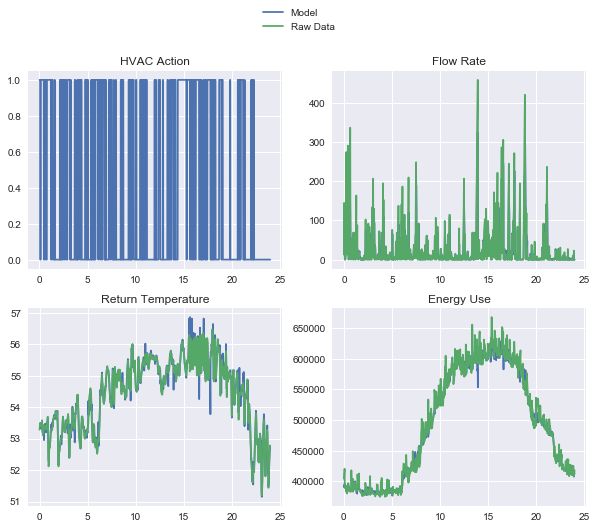

In [43]:
def raw_model(df,df_raw):

    # control the energy model using PID controller
    env = EnergyModelEnvironment(df)
    
    max_step = len(df.index)
    state_size = len(df.columns)-1
    done = False
    
    for time_step in range(1,max_step):
        env.current_step = time_step
        action = df_raw['Chilled Water Request'].iloc[time_step] 
        next_state,observations,reward,done = env.step(action)
        reward = env.reward
        next_state = np.reshape(next_state, [1,state_size])
        state = next_state
    
    fig_name = 'raw_data_strategy'
    make_plots(env.df, df_raw, fig_name)
    print("Final Reward: ", env.reward)
    
    return env.reward, env.df
    
raw_data_reward, raw_data_df = raw_model(data,data_raw)

In [14]:
raw_data_df.head()

,Unnamed: 0,Time,CHWST,OA Humidity,OA Temperature,3rd Floor AHU-1|SA Airflow,3rd Floor AHU-2|SA Airflow,3rd Floor AHU-3|SA Airflow,3rd Floor AHU-7|SA Airflow,3rd Floor AHU-8|SA Airflow,...,Roof AHU-10|RA Humidity,Roof AHU-11|RA Humidity,Roof AHU-12|RA Humidity,Roof AHU-9|RA Humidity,Run Time,Flow Rate,Return Temperature,Action,Power,Power Actual
0,0,0,46.400002,90.519997,72.292000,1532.060059,0.0,1640.346558,1679.903198,10463.95605,...,55.450722,53.867073,53.043949,54.188179,1,79.969933,53.282894,1.0,NaN,413680
1,1,1,46.400002,90.508080,72.292000,1561.681641,0.0,1603.631104,1666.561646,10488.05664,...,55.568371,53.880249,52.599510,54.193092,2,79.919930,53.305338,1.0,392806.287517,404159
2,2,2,46.234203,90.490074,72.310303,1597.395996,0.0,1556.358643,1646.811768,10506.84668,...,55.188408,53.900249,51.953472,54.217091,3,79.012653,53.368211,1.0,391005.613322,408172
3,3,3,46.282761,90.472076,72.331894,1633.110474,0.0,1509.086060,1627.062012,10525.63672,...,54.808441,53.920254,51.307430,54.241093,4,72.860254,53.438978,1.0,390168.292935,412268
4,4,4,46.217072,90.454071,72.353485,1668.824951,0.0,1461.813477,1607.312256,10544.42676,...,54.428478,53.940254,50.661392,54.265091,5,75.436746,53.491213,1.0,389884.885680,416364


In [15]:
raw_energy = raw_data_df['Power Actual'].sum()*60*10**-9*.28
raw_strategy_energy = raw_data_df['Power'].sum()*60*10**-9*.28

In [16]:
print(raw_energy, raw_strategy_energy)

11.966443944000002 11.913443759668262


In [17]:
NN_energy = df['Power'].sum()*60*10**-9*.28
print(NN_energy)

11.90176901248524


In [87]:
percent = 100-NN_energy/raw_energy*100
# varies from [0.54 to 0.67 %]
print("Neural Network strategy used ", np.round(percent,2), "% less energy")
print("Neural Network strategy used ", 10**3*(raw_energy-NN_energy),"kWh less energy")

Neural Network strategy used  0.54 % less energy
Neural Network strategy used  64.67493151476233 kWh less energy
